In [26]:
import pandas as pd
import numpy as np
import torch
from config import basic_conf as conf
from libs import ModelManager as mm
from config.constants import HyperParamKey, LoadingKey
from libs.data_loaders.SNLILoader import snli_collate_func, SNLIDataset
import torch.nn.functional as F
from torch.utils.data import DataLoader

import logging

import matplotlib.pyplot as plt
from importlib import reload

%matplotlib inline

In [2]:
# in this example we init logger with level = INFO and see that the info logs get outputted
conf.init_logger(logging.INFO, logfile=None)
logger = logging.getLogger('__main__')
mgr = mm.ModelManager(mode='notebook')

[2018-10-28 18:52:42] [INFO] Initializing Model Manager, version 0.5.0 ...
[2018-10-28 18:52:42] [INFO] 
=== Models Available ===
BagOfWords
NLIRNN
NLICNN
[2018-10-28 18:52:42] [INFO] 
=== Loaders Available ===
IMDB
SNLI
MNLI
[2018-10-28 18:52:42] [INFO] 
*********** Model Manager Details ***********
-- self.hparams.num_epochs = 10
-- self.hparams.lr = 0.01
-- self.hparams.voc_size = 100000
-- self.hparams.train_loop_check_freq = 10
-- self.hparams.dropout_rnn = 0.5
-- self.hparams.dropout_fc = 0.5
-- self.hparams.batch_size = 256
-- self.hparams.fc_hidden_size = 100
-- self.hparams.rnn_hidden_size = 50
-- self.hparams.cnn_hidden_size = 100
-- self.hparams.cnn_kernal_size = 3
-- self.hparams.rnn_num_layers = 1
-- self.hparams.check_early_stop = True
-- self.hparams.es_look_back = 50
-- self.hparams.no_imp_look_back = 25
-- self.hparams.decay_lr_no_improv = 0.5
-- self.hparams.es_req_prog = 0.0
-- self.hparams.optim_enc = <class 'torch.optim.adam.Adam'>
-- self.hparams.optim_dec = <clas

In [3]:
mgr.load_data(mm.loaderRegister.SNLI)

[2018-10-28 18:52:44] [INFO] Loading data using SNLI ...
[2018-10-28 18:52:44] [INFO] loading raw training data set ...
[2018-10-28 18:52:44] [INFO] loading raw training data set ...
[2018-10-28 18:52:44] [INFO] loading pre-trained word vectors, building vocab ...
[2018-10-28 18:52:57] [INFO] converting training set to index ...
[2018-10-28 18:52:58] [INFO] converting val set to index ...
[2018-10-28 18:52:58] [INFO] piping data into pytorch DataLoaders ...


In [4]:
hparams={
    HyperParamKey.LR: 0.01,
    HyperParamKey.SCHEDULER_GAMMA: 0.95,
    HyperParamKey.BATCH_SIZE: 256,
    HyperParamKey.RNN_HIDDEN_SIZE: 100,
    HyperParamKey.DROPOUT_FC: 0.25,
    HyperParamKey.DROPOUT_RNN: 0.25,
    HyperParamKey.NO_IMPROV_LOOK_BACK: 25
}
mgr.hparams.update(hparams)
mgr.new_model(mm.modelRegister.NLIRNN, label='modlrinv100decay95rhs100drop25')
mgr.load_model(which_model=LoadingKey.LOAD_BEST)
mgr.propogate_params()

[2018-10-28 18:52:58] [INFO] 
*********** Model: modlrinv100decay95rhs100drop25 Details ***********
-- self.label = modlrinv100decay95rhs100drop25
-- self.hparams.num_epochs = 10
-- self.hparams.lr = 0.01
-- self.hparams.voc_size = 100000
-- self.hparams.train_loop_check_freq = 10
-- self.hparams.dropout_rnn = 0.25
-- self.hparams.dropout_fc = 0.25
-- self.hparams.batch_size = 256
-- self.hparams.fc_hidden_size = 100
-- self.hparams.rnn_hidden_size = 100
-- self.hparams.cnn_hidden_size = 100
-- self.hparams.cnn_kernal_size = 3
-- self.hparams.rnn_num_layers = 1
-- self.hparams.check_early_stop = True
-- self.hparams.es_look_back = 50
-- self.hparams.no_imp_look_back = 25
-- self.hparams.decay_lr_no_improv = 0.5
-- self.hparams.es_req_prog = 0.0
-- self.hparams.optim_enc = <class 'torch.optim.adam.Adam'>
-- self.hparams.optim_dec = <class 'torch.optim.adam.Adam'>
-- self.hparams.scheduler = <class 'torch.optim.lr_scheduler.ExponentialLR'>
-- self.hparams.scheduler_gamma = 0.95
-- self.h

In [41]:
ds = SNLIDataset(mgr.dataloader.data['val'])
dl = DataLoader(dataset=ds,
                batch_size=1,
                collate_fn=snli_collate_func,
                shuffle=False)

for i, (sent1_batch, sent2_batch, len1_batch, len2_batch, label_batch) in enumerate(dl):
    print("--- EXAMPLE %s ---" % (i + 1))
    outputs = F.softmax(mgr.model.model(sent1_batch,
                                        sent2_batch,
                                        len1_batch,
                                        len2_batch), 
                        dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    
    label_val = label_batch.cpu().numpy()[0]
    pred_val = predicted.cpu().numpy()[0][0]
    
    print(mgr.dataloader.data['val'][i].raw_tuple[0],"\n")
    print(mgr.dataloader.data['val'][i].raw_tuple[1],"\n")
    print("label:", mgr.dataloader.data['val'][i].label)
    print("label check:", label_val)
    print("predicted:", pred_val)
    
    if label_val == pred_val:
        print("CORRECT!")
    else:
        print("WRONG!")
    
    if i >= 10:
        break

--- EXAMPLE 1 ---
three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument . 

there are two women standing on the stage 

label: 1
label check: 1
predicted: 0
WRONG!
--- EXAMPLE 2 ---
four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots . 

multiple people are on a subway together , with each of them doing their own thing . 

label: 0
label check: 0
predicted: 0
CORRECT!
--- EXAMPLE 3 ---
bicycles stationed while a group of people socialize . 

people get together near a stand of bicycles . 

label: 0
label check: 0
predicted: 0
CORRECT!
--- EXAMPLE 4 ---
man in overalls with two horses . 

a man in overalls with two horses 

label: 0
label check: 0
predicted: 0
CORRECT!
--- EXAMPLE 5 ---
man observes a wavelength given off by an electronic device . 

th

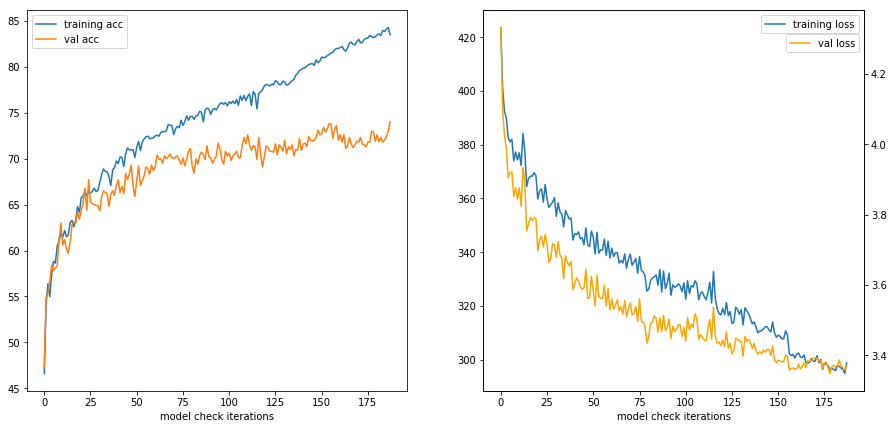

In [6]:
mgr.graph_training_curves()

In [9]:
hparams={
    HyperParamKey.LR: 0.001,
    HyperParamKey.CNN_HIDDEN_SIZE: 200,
    HyperParamKey.CNN_KERNAL_SIZE: 3
}
mgr.hparams.update(hparams)
mgr.new_model(mm.modelRegister.NLICNN, label='cnnlrinv1000hs200kern3')
mgr.load_model(which_model=LoadingKey.LOAD_BEST)
mgr.propogate_params()

[2018-10-28 15:49:21] [INFO] 
*********** Model: cnnlrinv1000hs200kern3 Details ***********
-- self.label = cnnlrinv1000hs200kern3
-- self.hparams.num_epochs = 10
-- self.hparams.lr = 0.001
-- self.hparams.voc_size = 100000
-- self.hparams.train_loop_check_freq = 10
-- self.hparams.dropout_rnn = 0.25
-- self.hparams.dropout_fc = 0.25
-- self.hparams.batch_size = 256
-- self.hparams.fc_hidden_size = 100
-- self.hparams.rnn_hidden_size = 100
-- self.hparams.cnn_hidden_size = 200
-- self.hparams.cnn_kernal_size = 3
-- self.hparams.rnn_num_layers = 1
-- self.hparams.check_early_stop = True
-- self.hparams.es_look_back = 50
-- self.hparams.no_imp_look_back = 25
-- self.hparams.decay_lr_no_improv = 0.5
-- self.hparams.es_req_prog = 0.0
-- self.hparams.optim_enc = <class 'torch.optim.adam.Adam'>
-- self.hparams.optim_dec = <class 'torch.optim.adam.Adam'>
-- self.hparams.scheduler = <class 'torch.optim.lr_scheduler.ExponentialLR'>
-- self.hparams.scheduler_gamma = 0.95
-- self.hparams.criterio

In [10]:
mgr.model.eval_model(mgr.dataloader.loaders['val'])

(70.3, 3.550516128540039)

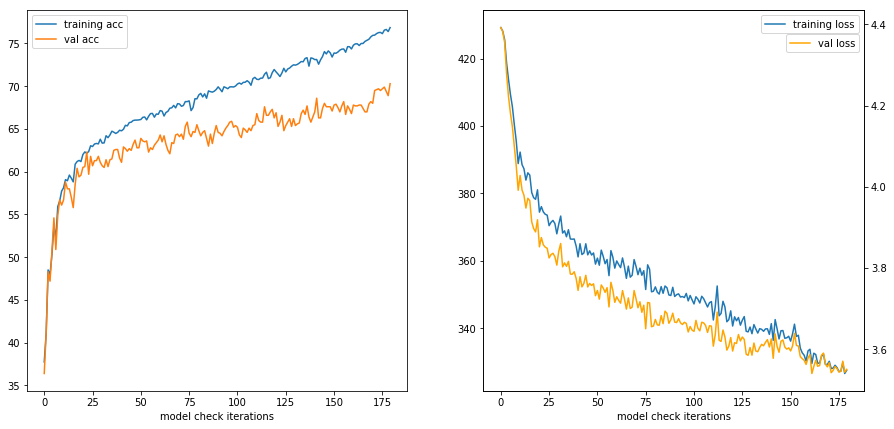

In [11]:
mgr.graph_training_curves()

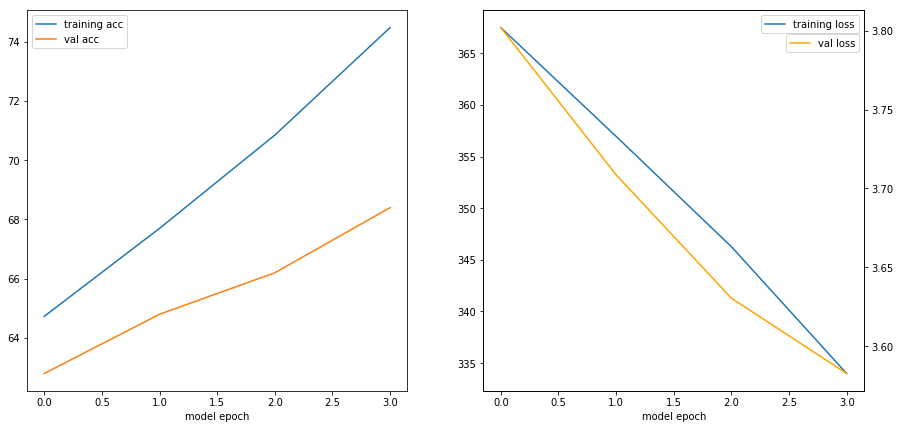

In [12]:
mgr.graph_training_curves(mgr.GRAPH_MODE_EPOCH)